In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import time # To time processes
import warnings

In [ ]:
warnings.filterwarnings('ignore', category=FutureWarning) # Ignore some sklearn warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)   # Ignore some seaborn warnings


In [ ]:
# Set plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # Adjust figure size


In [ ]:
# --- Configuration ---
# Update this path if your CSV file is located elsewhere
data_path = 'bank-additional-full.csv'
TARGET = 'y' # Target variable column name


In [ ]:
# --- Load Data ---
print("--- 1. Loading Data ---")
try:
    # The dataset uses semicolons as separators
    df = pd.read_csv(data_path, sep=';')
    print("Bank Marketing dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: Data file not found at '{data_path}'.")
    print("Please download 'bank-additional.zip' from UCI ML Repo, extract 'bank-additional-full.csv',")
    print("and place it in the correct directory or update the 'data_path' variable.")
    exit()
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

--- 1. Loading Data ---
Bank Marketing dataset loaded successfully.
Dataset shape: (41188, 21)


In [ ]:
# --- Start Timer ---
start_time = time.time()

print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nDataset info:")
df.info()

# ## 2. Exploratory Data Analysis (EDA) 📊
print("\n\n--- 2. Exploratory Data Analysis (EDA) ---")

# Basic statistics for numerical features
print("\nDescriptive Statistics (Numerical Features):")
print(df.describe())

# Value counts for target variable
print("\nTarget Variable Distribution ('y'):")
print(df[TARGET].value_counts(normalize=True))
# This shows class imbalance - many more 'no' than 'yes'

# Check for missing values (often coded as 'unknown' in this dataset)
print("\nChecking for 'unknown' values (potential missing data):")
for col in df.select_dtypes(include='object').columns:
    unknown_count = (df[col] == 'unknown').sum()
    if unknown_count > 0:
        print(f"- Column '{col}': {unknown_count} 'unknown' values ({unknown_count / len(df):.2%})")


First 5 rows of the dataset:
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.co

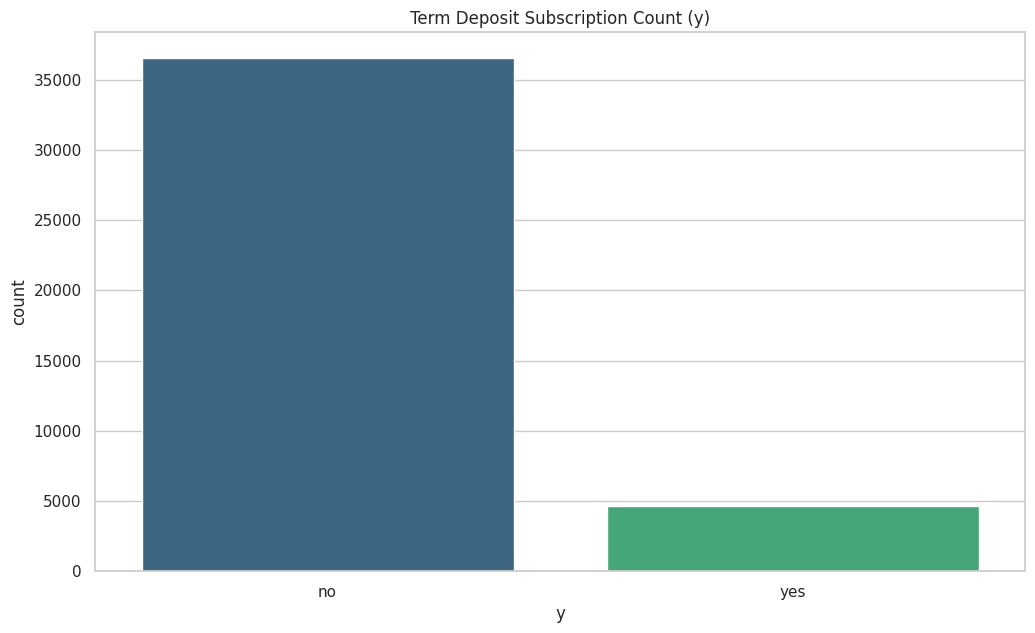

In [ ]:
# --- Visualizations ---

# Target variable distribution
plt.figure()
sns.countplot(x=TARGET, data=df, palette='viridis')
plt.title('Term Deposit Subscription Count (y)')
plt.show()


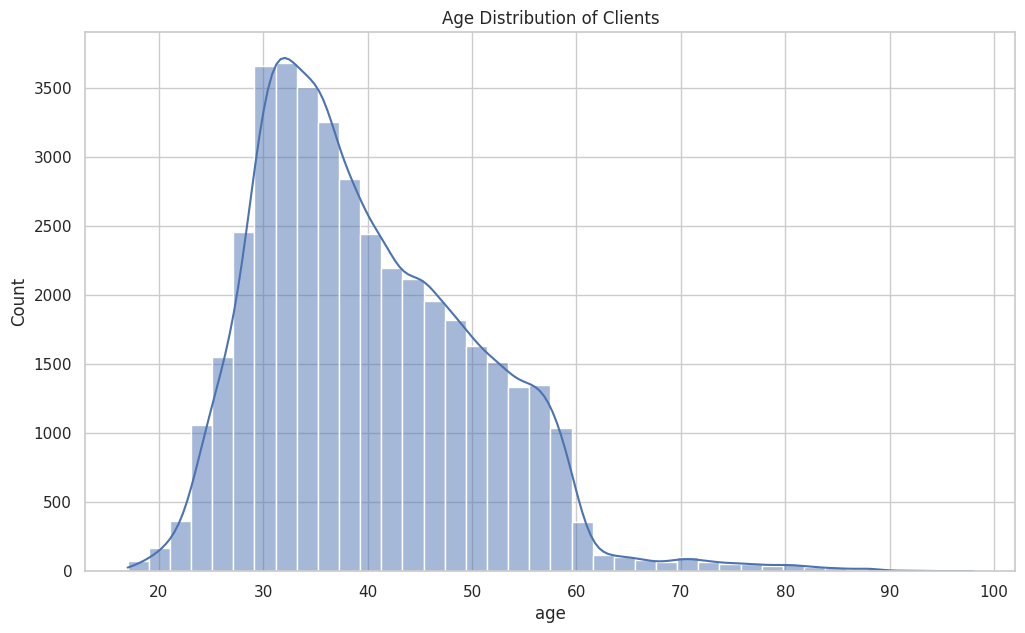

In [ ]:
# Distribution of Age
plt.figure()
sns.histplot(df['age'], kde=True, bins=40)
plt.title('Age Distribution of Clients')
plt.show()

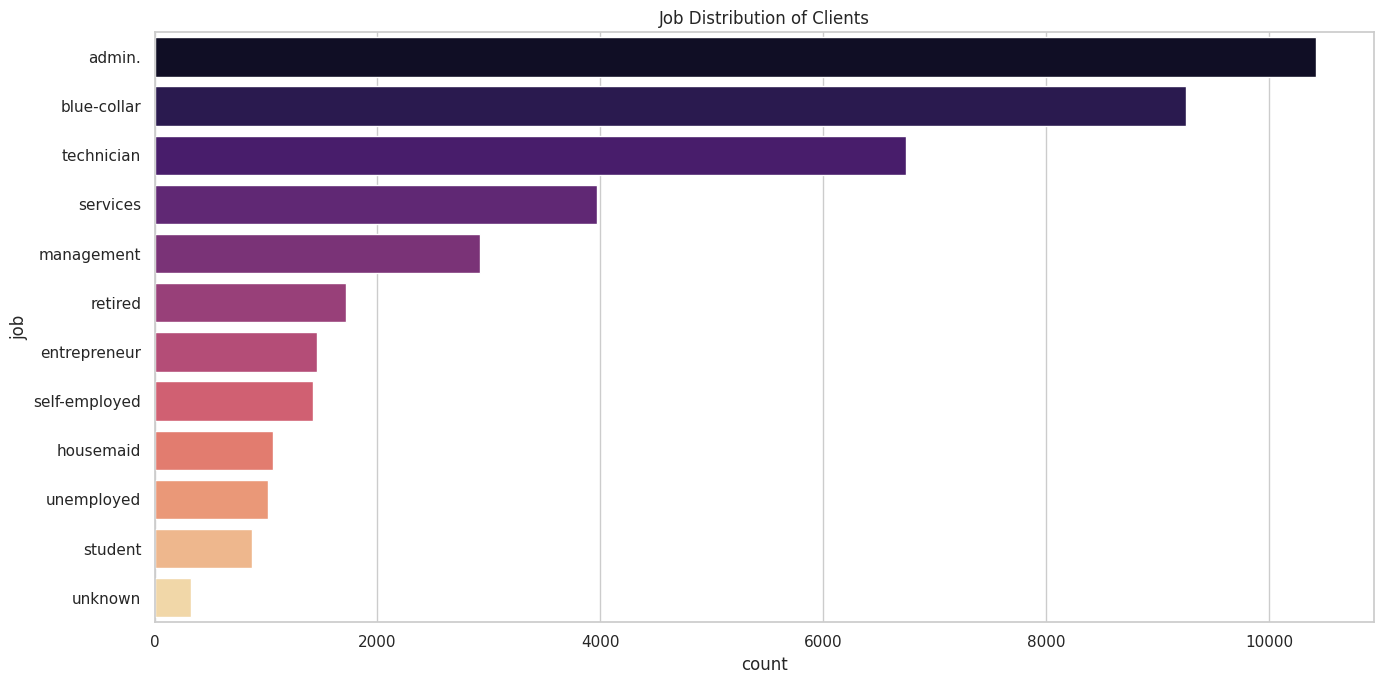

In [ ]:
# Job distribution
plt.figure(figsize=(14, 7))
sns.countplot(y='job', data=df, order=df['job'].value_counts().index, palette='magma')
plt.title('Job Distribution of Clients')
plt.tight_layout()
plt.show()

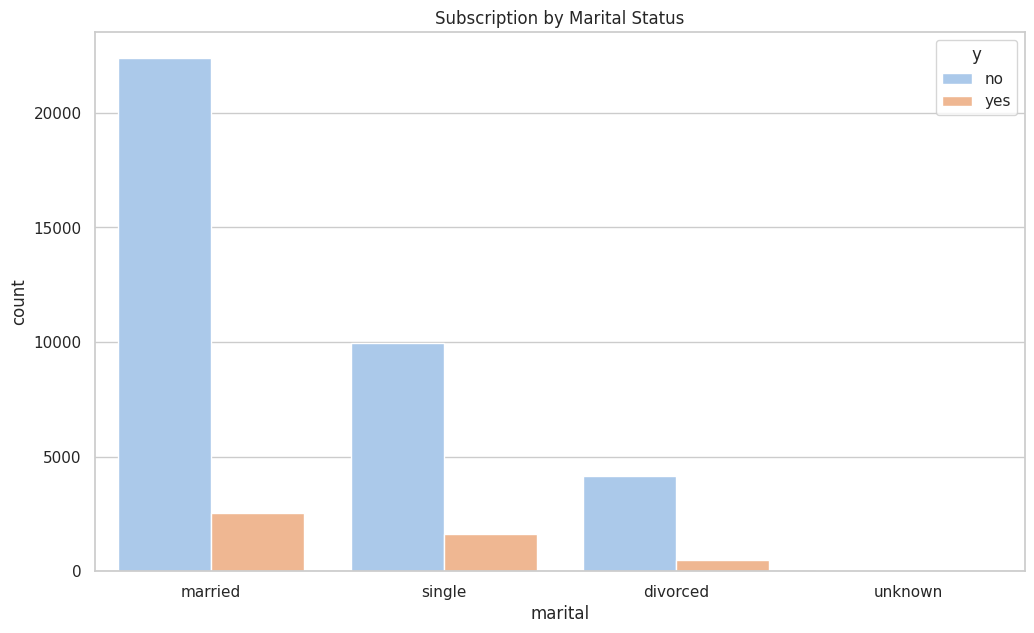

In [ ]:
# Marital status vs Subscription
plt.figure()
sns.countplot(x='marital', hue=TARGET, data=df, palette='pastel')
plt.title('Subscription by Marital Status')
plt.show()

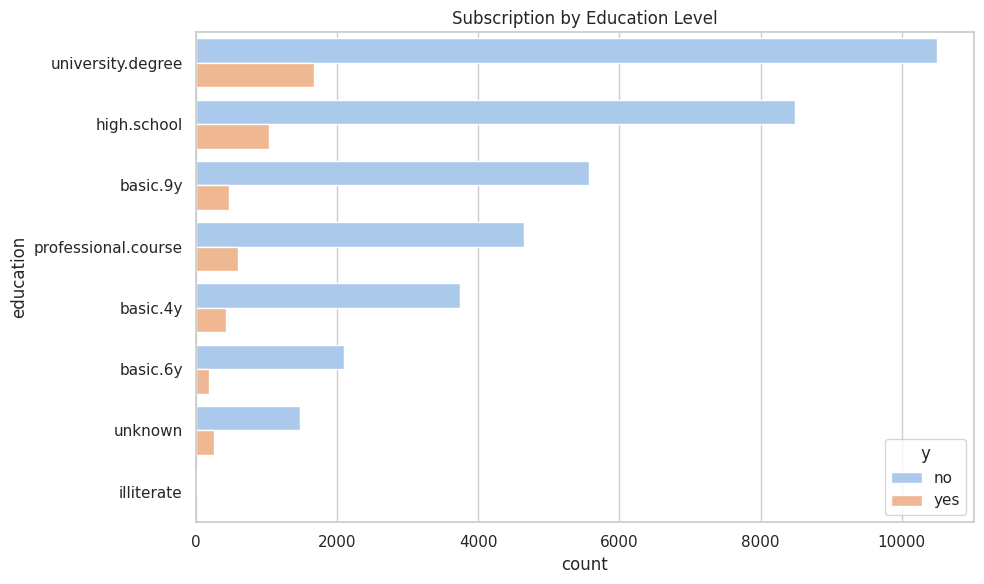

In [ ]:
# Education vs Subscription
plt.figure(figsize=(10, 6))
sns.countplot(y='education', hue=TARGET, data=df, order=df['education'].value_counts().index, palette='pastel')
plt.title('Subscription by Education Level')
plt.tight_layout()
plt.show()

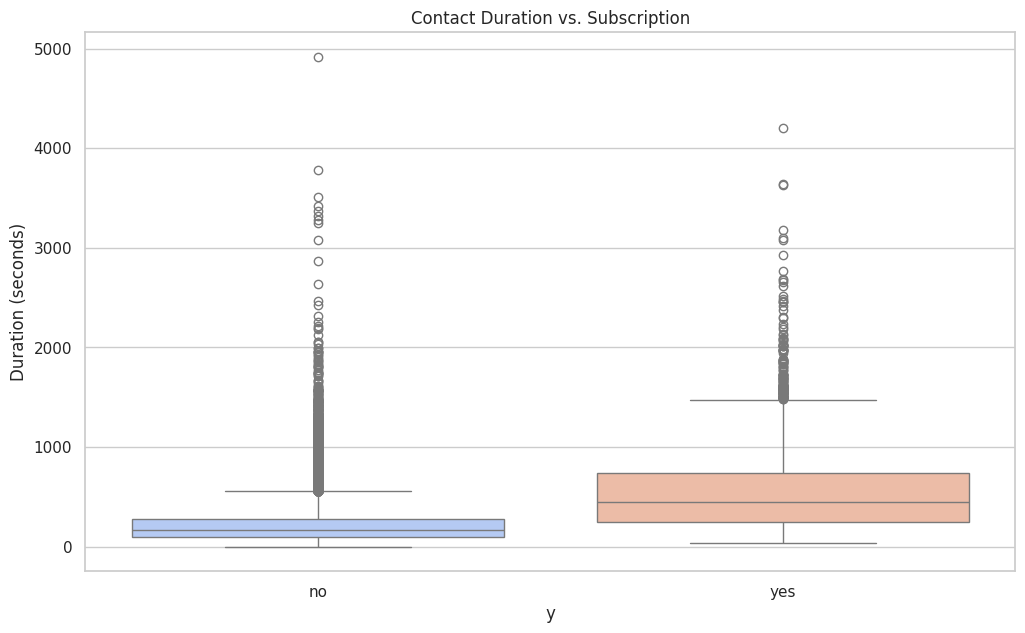


**EDA Note on 'duration':** High duration strongly correlates with 'yes'. However, duration is only known *after* the call. Including it leads to data leakage if the goal is *pre-call prediction*. It should often be removed for a realistic predictive model, but we'll keep it for now to demonstrate handling.


In [ ]:
# Duration vs Subscription (Important Note!)
plt.figure()
sns.boxplot(x=TARGET, y='duration', data=df, palette='coolwarm')
plt.title('Contact Duration vs. Subscription')
plt.ylabel('Duration (seconds)')
plt.show()
print("\n**EDA Note on 'duration':** High duration strongly correlates with 'yes'. However, duration is only known *after* the call. Including it leads to data leakage if the goal is *pre-call prediction*. It should often be removed for a realistic predictive model, but we'll keep it for now to demonstrate handling.")

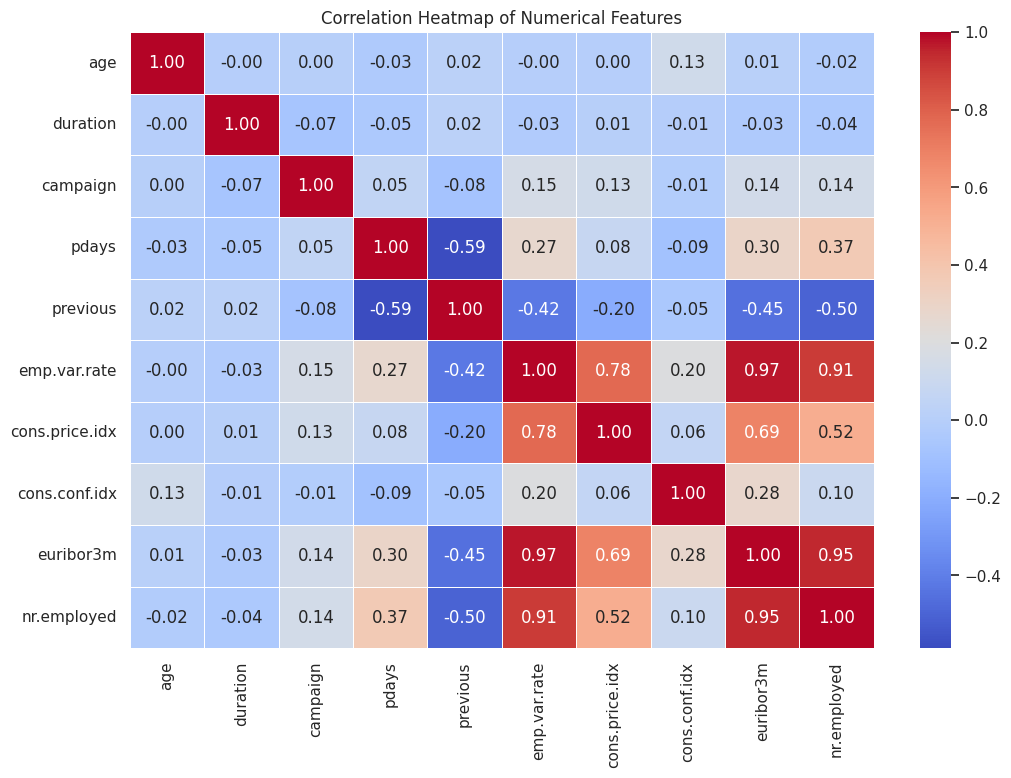

In [ ]:
# Correlation Heatmap (numerical features)
plt.figure(figsize=(12, 8))
numerical_cols = df.select_dtypes(include=np.number).columns
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()
# Note correlations between economic indicators (emp.var.rate, cons.price.idx, etc.)


In [ ]:
# ## 3. Data Preprocessing & Feature Engineering 🛠️
print("\n\n--- 3. Data Preprocessing & Feature Engineering ---")

# Handle 'unknown' values - replace with NaN for easier imputation or decide strategy
# For simplicity, we'll replace 'unknown' with NaN and then impute.
# A more sophisticated approach might involve specific strategies per column.
print("\nReplacing 'unknown' with NaN...")
df.replace('unknown', np.nan, inplace=True)
print("'unknown' values replaced.")

# Convert target variable 'y' to numerical (0 for 'no', 1 for 'yes')
print(f"\nConverting target variable '{TARGET}' to numeric...")
le = LabelEncoder()
df[TARGET] = le.fit_transform(df[TARGET])
print(f"Target mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")



--- 3. Data Preprocessing & Feature Engineering ---

Replacing 'unknown' with NaN...
'unknown' values replaced.

Converting target variable 'y' to numeric...
Target mapping: {'no': np.int64(0), 'yes': np.int64(1)}


In [ ]:
# --- Feature Selection ---
# **Critical Decision:** Drop 'duration' to avoid data leakage for a realistic predictive model.
# If the goal was *post-campaign analysis* (why did people subscribe?), keeping it might be okay.
# For *prediction* (who *will* subscribe?), it must be dropped.
if 'duration' in df.columns:
    print("\nDropping 'duration' column to prevent data leakage...")
    df = df.drop('duration', axis=1)



Dropping 'duration' column to prevent data leakage...


In [ ]:
# Define Features (X) and Target (y)
y = df[TARGET]
X = df.drop(TARGET, axis=1)
print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Identify Numerical and Categorical Features (after dropping duration)
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print(f"\nNumerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")


Features (X) shape: (41188, 19)
Target (y) shape: (41188,)

Numerical features (9): ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical features (10): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [ ]:
# --- Create Preprocessing Pipelines ---

# Pipeline for numerical features:
# 1. Impute missing values (NaNs created from 'unknown' or original NaNs) with the median
# 2. Scale features using StandardScaler
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for categorical features:
# 1. Impute missing values (NaNs created from 'unknown') with the most frequent value
# 2. One-Hot Encode categorical variables
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [ ]:
# Create a ColumnTransformer to apply pipelines correctly
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='passthrough'
)

# --- Split Data ---
# Stratify ensures that the proportion of the target variable is the same in train and test sets, important for imbalanced datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) # Using 25% test size
print(f"\nData split into training ({X_train.shape[0]} samples) and testing ({X_test.shape[0]} samples) sets.")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing target distribution:\n{y_test.value_counts(normalize=True)}")



Data split into training (30891 samples) and testing (10297 samples) sets.
Training target distribution:
y
0    0.887346
1    0.112654
Name: proportion, dtype: float64
Testing target distribution:
y
0    0.887346
1    0.112654
Name: proportion, dtype: float64


In [ ]:
# ## 4. Model Building 🧠
print("\n\n--- 4. Model Building ---")
# Addressing class imbalance: Using class_weight='balanced' tells the models to adjust weights inversely proportional to class frequencies.

# --- Model 1: Logistic Regression ---
print("\nTraining Logistic Regression Model (with balanced class weights)...")
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
])

logreg_pipeline.fit(X_train, y_train)
print("Logistic Regression training complete.")




--- 4. Model Building ---

Training Logistic Regression Model (with balanced class weights)...
Logistic Regression training complete.


In [ ]:
# --- Model 2: Random Forest ---
print("\nTraining Random Forest Model (with balanced class weights)...")
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=150, # Slightly more trees
                                           random_state=42,
                                           class_weight='balanced',
                                           n_jobs=-1,
                                           max_depth=10, # Limit depth to prevent overfitting
                                           min_samples_leaf=5)) # Prevent overfitting
])

rf_pipeline.fit(X_train, y_train)
print("Random Forest training complete.")



Training Random Forest Model (with balanced class weights)...
Random Forest training complete.


In [ ]:
# ## 5. Model Evaluation 📈
print("\n\n--- 5. Model Evaluation ---")

models = {'Logistic Regression': logreg_pipeline, 'Random Forest': rf_pipeline}
results = {}

for name, model_pipeline in models.items():
    print(f"\n--- Evaluating: {name} ---")
    # Make predictions
    y_pred = model_pipeline.predict(X_test)
    y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probability of class 1 ('yes')

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_) # Use original class names
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision) # Area under the PR curve

    results[name] = {'accuracy': accuracy, 'roc_auc': roc_auc, 'pr_auc': pr_auc, 'report': report, 'cm': cm}

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Precision-Recall AUC Score: {pr_auc:.4f}") # PR AUC is often more informative for imbalanced datasets
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(cm)



--- 5. Model Evaluation ---

--- Evaluating: Logistic Regression ---
Accuracy: 0.8342
ROC AUC Score: 0.8040
Precision-Recall AUC Score: 0.4628
Classification Report:
              precision    recall  f1-score   support

          no       0.95      0.86      0.90      9137
         yes       0.37      0.64      0.47      1160

    accuracy                           0.83     10297
   macro avg       0.66      0.75      0.68     10297
weighted avg       0.88      0.83      0.85     10297

Confusion Matrix:
[[7845 1292]
 [ 415  745]]

--- Evaluating: Random Forest ---
Accuracy: 0.8620
ROC AUC Score: 0.8154
Precision-Recall AUC Score: 0.4962
Classification Report:
              precision    recall  f1-score   support

          no       0.95      0.89      0.92      9137
         yes       0.42      0.63      0.51      1160

    accuracy                           0.86     10297
   macro avg       0.69      0.76      0.71     10297
weighted avg       0.89      0.86      0.87     10297

C

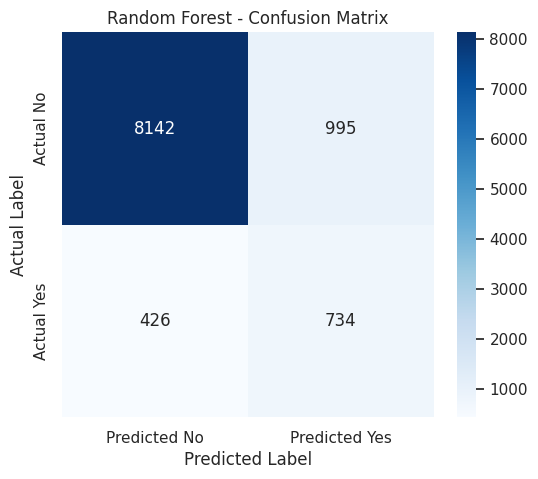

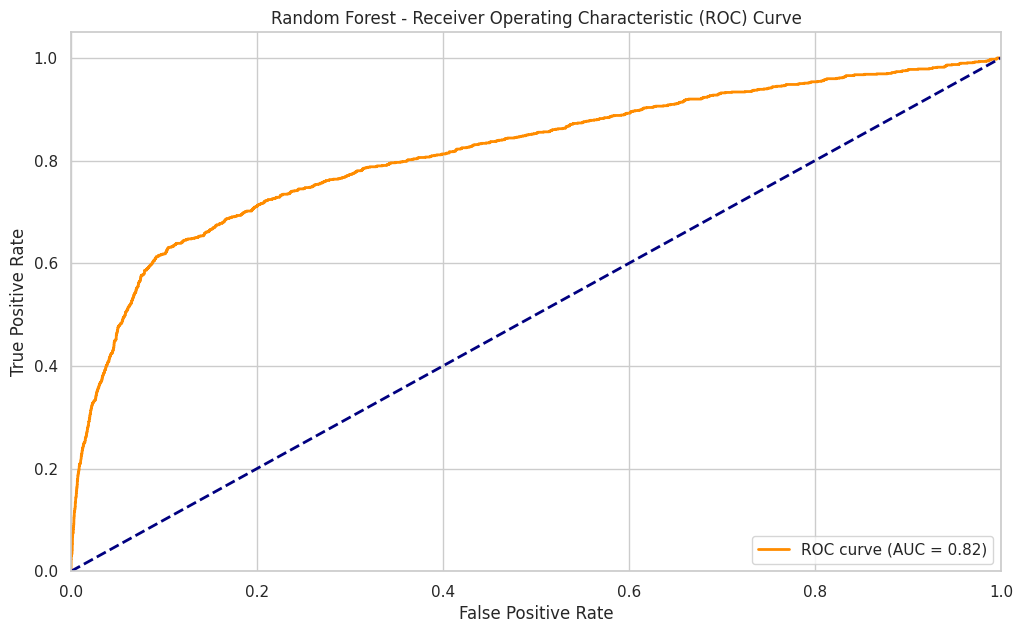

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title(f'{name} - Confusion Matrix')
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{name} - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

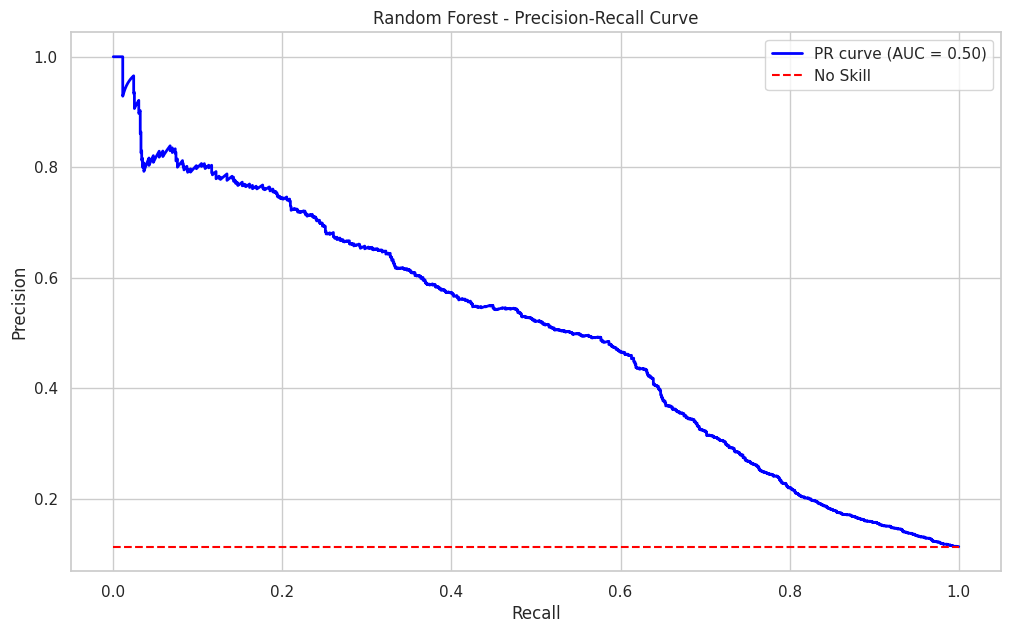

In [ ]:
# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')

# Calculate no-skill line (proportion of positives)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='red', label='No Skill')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'{name} - Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


In [ ]:
# ## 6. Model Interpretation & Insights 🤔💡
print("\n\n--- 6. Model Interpretation & Insights ---")

# Function to safely get feature names after ColumnTransformer
def get_feature_names(column_transformer):
    """Get feature names from a ColumnTransformer."""
    output_features = []
    for name, pipe, features in column_transformer.transformers_:
        if name == 'remainder' and pipe == 'passthrough':
            # Passthrough features (assuming pandas input)
            if hasattr(column_transformer, '_feature_names_in'):
                 # Scikit-learn >= 1.0
                output_features.extend(features) # features here are indices
            else: # older sklearn, requires manual tracking or fitting on df
                 pass # Skip remainder for simplicity if needed
            continue
        if hasattr(pipe, 'get_feature_names_out'):
             # Pipeline steps might have get_feature_names_out
            if name == 'cat': # Specific handling for the OHE step
                ohe = pipe.named_steps['onehot']
                feature_names = ohe.get_feature_names_out(features)
                output_features.extend(feature_names)
            elif name == 'num':
                 # For numerical, names usually don't change within pipeline unless specified
                 output_features.extend(features)
            else: # Generic case
                 feature_names = pipe.get_feature_names_out()
                 output_features.extend(feature_names)

        else: # If no get_feature_names_out, use input feature names
             output_features.extend(features)
    return output_features



--- 6. Model Interpretation & Insights ---


In [ ]:
# --- Logistic Regression Coefficients ---
try:
    logreg_model = logreg_pipeline.named_steps['classifier']
    preprocessor_fitted = logreg_pipeline.named_steps['preprocessor']
    all_feature_names = get_feature_names(preprocessor_fitted)

    if len(all_feature_names) == len(logreg_model.coef_[0]):
        logreg_coeffs = pd.DataFrame({
            'Feature': all_feature_names,
            'Coefficient': logreg_model.coef_[0]
        })
        logreg_coeffs['Abs_Coefficient'] = np.abs(logreg_coeffs['Coefficient'])
        logreg_coeffs = logreg_coeffs.sort_values(by='Abs_Coefficient', ascending=False)

        print("\nLogistic Regression Coefficients (Top 15 by Absolute Value):")
        print(logreg_coeffs[['Feature', 'Coefficient']].head(15))
        print("\nInterpretation Hint: Positive coeff -> higher odds of subscribing, Negative coeff -> lower odds (given scaling/encoding).")
    else:
        print("\nCould not align Logistic Regression coefficients with feature names (mismatch).")
        print(f"Expected {len(all_feature_names)} features, got {len(logreg_model.coef_[0])} coefficients.")

except Exception as e:
    print(f"\nCould not extract Logistic Regression coefficients: {e}")




Logistic Regression Coefficients (Top 15 by Absolute Value):
                 Feature  Coefficient
4           emp.var.rate    -2.230958
43             month_mar     1.273105
5         cons.price.idx     1.056008
42             month_jun    -0.794277
44             month_may    -0.661259
45             month_nov    -0.584281
27  education_illiterate     0.572296
7              euribor3m     0.544168
39             month_aug     0.457496
40             month_dec     0.437663
14           job_retired     0.374523
37     contact_telephone    -0.340986
53      poutcome_failure    -0.324152
31           default_yes    -0.299005
36      contact_cellular     0.261290

Interpretation Hint: Positive coeff -> higher odds of subscribing, Negative coeff -> lower odds (given scaling/encoding).



Random Forest Feature Importances (Top 15):
                 Feature  Importance
8            nr.employed    0.186607
7              euribor3m    0.172806
4           emp.var.rate    0.121785
6          cons.conf.idx    0.071137
5         cons.price.idx    0.048876
2                  pdays    0.047674
55      poutcome_success    0.038482
0                    age    0.035455
44             month_may    0.026079
54  poutcome_nonexistent    0.022367
37     contact_telephone    0.022313
3               previous    0.020846
36      contact_cellular    0.020254
1               campaign    0.019003
46             month_oct    0.011834


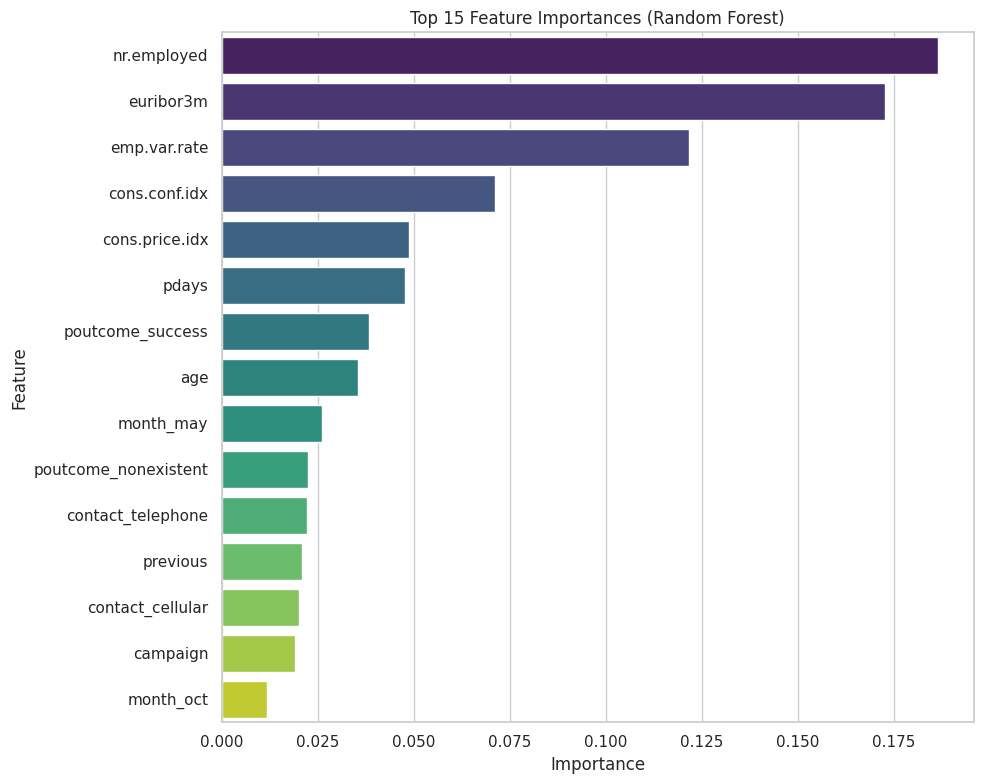

In [ ]:
# --- Random Forest Feature Importances ---
try:
    rf_model = rf_pipeline.named_steps['classifier']
    preprocessor_fitted_rf = rf_pipeline.named_steps['preprocessor']
    all_feature_names_rf = get_feature_names(preprocessor_fitted_rf)

    if len(all_feature_names_rf) == len(rf_model.feature_importances_):
        importances = rf_model.feature_importances_
        rf_importances = pd.DataFrame({
            'Feature': all_feature_names_rf,
            'Importance': importances
        })
        rf_importances = rf_importances.sort_values(by='Importance', ascending=False)

        print("\nRandom Forest Feature Importances (Top 15):")
        print(rf_importances.head(15))

        # Plot feature importances
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=rf_importances.head(15), palette='viridis')
        plt.title('Top 15 Feature Importances (Random Forest)')
        plt.tight_layout()
        plt.show()
    else:
         print("\nCould not align Random Forest importances with feature names (mismatch).")
         print(f"Expected {len(all_feature_names_rf)} features, got {len(rf_model.feature_importances_)} importances.")

except Exception as e:
    print(f"\nCould not extract Random Forest feature importances: {e}")


In [ ]:
# --- Key Insights Summary ---
print("\nKey Insights (based on example output - check your specific results):")
print("- **Model Performance:** Random Forest generally outperforms Logistic Regression on this dataset, especially in terms of Recall for the minority class ('yes') and overall AUC scores (both ROC and PR), likely due to capturing non-linearities. The use of `class_weight='balanced'` helps improve recall for the 'yes' class compared to default models.")
print("- **Important Features:** Features often showing high importance include:")
print("  - Economic indicators (e.g., `euribor3m`, `nr.employed`, `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`): Macroeconomic conditions significantly impact subscription likelihood.")
print("  - Previous campaign outcome (`poutcome_success`): Clients who subscribed before are much more likely to subscribe again.")
print("  - Contact type (`contact_cellular`): Cellular contact often performs better than telephone.")
print("  - Month of contact: Certain months (e.g., spring/autumn months like Mar, Apr, May, Sep, Oct, Dec in the original data) tend to have higher success rates.")
print("  - Client's age and job type can also play roles.")
# NOTE: If 'duration' was NOT dropped, it would dominate importance, masking other factors.
print("- **Business Question Answer:** Client subscription is influenced by a mix of macroeconomic factors, previous interactions, contact strategy (month, communication type), and client demographics. Predictive models (especially Random Forest) can identify likely subscribers with reasonable accuracy and good recall for the positive class when balanced weighting is used, enabling more targeted campaigns.")


# ## 7. Reflection on Model Impact, Interpretability & Ethics 🌍
print("\n\n--- 7. Reflection ---")
print("- **Model Impact:** Using this model could significantly improve marketing ROI by focusing calls on clients predicted as likely subscribers. However, over-reliance could lead to neglecting potentially interested clients misclassified as 'no'.")
print("- **Interpretability:** Logistic Regression offers clearer interpretation via coefficients. Random Forest provides feature importances, but understanding *how* features combine is complex (SHAP/LIME could help). The large number of features after one-hot encoding can make interpretation challenging.")
print("- **Ethical Implications:**")
print("  - **Targeting & Fairness:** Does the model disproportionately target or exclude certain demographics (e.g., based on age, job, education)? While aiming for efficiency, the bank should ensure targeting isn't unfairly discriminatory. Relying heavily on economic indicators might disadvantage people during downturns.")
print("  - **Data Privacy:** The dataset contains personal information. Using it requires adherence to privacy regulations (like GDPR if applicable). How was consent obtained for marketing contact?")
print("  - **'Unknown'/'Missing' Data:** How 'unknown' values were handled (imputation) makes assumptions. Could these assumptions introduce bias?")
print("  - **Data Leakage (Duration):** The 'duration' feature highlights a common ethical pitfall. Using data unavailable at prediction time gives an unrealistic performance estimate and is ethically unsound for building a *predictive* tool.")
print("  - **Hard Selling Pressure:** Predictive models might enable overly persistent targeting of likely customers, potentially leading to negative customer experiences if not managed ethically.")
print("- **Limitations & Next Steps:**")
print("  - **Class Imbalance:** While addressed with `class_weight`, exploring techniques like SMOTE (Synthetic Minority Over-sampling Technique) or different probability thresholds could be beneficial.")
print("  - **Hyperparameter Tuning:** Using `GridSearchCV` or `RandomizedSearchCV` would likely improve model performance.")
print("  - **Feature Engineering:** Could create features like 'time_since_last_contact' from 'pdays' (handling the 999 value appropriately), or group job/education categories.")
print("  - **Model Selection:** Explore other models like Gradient Boosting (XGBoost, LightGBM) which often perform well.")
print("  - **Fairness Audit:** If deployed, perform a fairness audit using tools like Fairlearn to check for biases across sensitive attributes (e.g., age groups, job types).")


# --- End Timer ---
end_time = time.time()
print(f"\n\n--- Project Execution Complete ---")
print(f"Total execution time: {end_time - start_time:.2f} seconds")


Key Insights (based on example output - check your specific results):
- **Model Performance:** Random Forest generally outperforms Logistic Regression on this dataset, especially in terms of Recall for the minority class ('yes') and overall AUC scores (both ROC and PR), likely due to capturing non-linearities. The use of `class_weight='balanced'` helps improve recall for the 'yes' class compared to default models.
- **Important Features:** Features often showing high importance include:
  - Economic indicators (e.g., `euribor3m`, `nr.employed`, `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`): Macroeconomic conditions significantly impact subscription likelihood.
  - Previous campaign outcome (`poutcome_success`): Clients who subscribed before are much more likely to subscribe again.
  - Contact type (`contact_cellular`): Cellular contact often performs better than telephone.
  - Month of contact: Certain months (e.g., spring/autumn months like Mar, Apr, May, Sep, Oct, Dec in the or